### 协同过滤、内容过滤、混合推荐——年龄、职业、电影类别

In [13]:
import pandas as pd
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from surprise import KNNWithMeans
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
# 加载数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [15]:
from surprise import Dataset, Reader, SVD, accuracy
# 数据预处理
age_encoder = LabelEncoder()
occupation_encoder = LabelEncoder()
users['Age'] = age_encoder.fit_transform(users['Age'])
users['Occupation'] = occupation_encoder.fit_transform(users['Occupation'])

# 合并用户数据和评分数据
merged_data = pd.merge(ratings, users, on='UserID')

# 加载Surprise数据集
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_data[['UserID', 'MovieID', 'Rating']], reader)

# 训练和测试数据集划分
trainset, testset = train_test_split(data, test_size=0.2)

In [16]:
# 使用SVD进行协同过滤
svd = SVD()
svd.fit(trainset)

# 评价SVD模型性能
predictions = svd.test(testset)
print("SVD - RMSE: ", accuracy.rmse(predictions))
print("SVD - MAE: ", accuracy.mae(predictions))

RMSE: 0.8740
SVD - RMSE:  0.8740474928868466
MAE:  0.6862
SVD - MAE:  0.6862480827750904


In [17]:
# 使用TF-IDF进行内容过滤
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['Genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [18]:
# 协同过滤推荐
def collaborative_filtering_recommendations(user_id, n=10):
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_watched = user_ratings['MovieID'].tolist()
    movie_ids = movies['MovieID'].tolist()
    recommendations = []
    for movie_id in movie_ids:
        if (movie_id not in user_watched):
            est = svd.predict(user_id, movie_id).est
            recommendations.append((movie_id, est))
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    top_n_recommendations = [(movies[movies['MovieID'] == movie_id]['Title'].values[0], movies[movies['MovieID'] == movie_id]['Genres'].values[0]) for movie_id, _ in recommendations[:n]]
    return top_n_recommendations

In [19]:
# 内容过滤推荐
def content_based_recommendations(title, n=10):
    idx = movies[movies['Title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_n_similar = [(movies['Title'].iloc[i[0]], movies['Genres'].iloc[i[0]]) for i in sim_scores[1:n+1]]
    return top_n_similar

In [20]:
# 混合推荐
def hybrid_recommendations(user_id, title, alpha=0.5, n=10):
    content_recs = content_based_recommendations(title, n)
    collab_recs = collaborative_filtering_recommendations(user_id, n)
    
    content_recs_set = set(content_recs)
    collab_recs_set = set(collab_recs)
    
    common_recs = content_recs_set.intersection(collab_recs_set)
    unique_recs = content_recs_set.union(collab_recs_set) - common_recs
    
    final_recs = list(common_recs) + list(unique_recs)
    return final_recs[:n]

In [21]:
content_sim_dict = {}
for idx, title in enumerate(movies['Title']):
    content_sim_dict[title] = content_based_recommendations(title, 1)

In [22]:
# 模型评估
def evaluate_collaborative_model():
    y_true = []
    y_pred = []
    for uid, iid, true_r, _ in ratings.itertuples(index=False):
        y_true.append(true_r)
        y_pred.append(round(svd.predict(uid, iid).est))  # 将预测值四舍五入以转化为离散值
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f'Collaborative Filtering - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    
def evaluate_content_based_model():
# 由于内容过滤是基于电影的相似性而非用户行为，所以不使用精确度、召回率和F1评分进行评估
    pass

def evaluate_hybrid_model():
    y_true = []
    y_pred = []
    for uid, iid, true_r, _ in ratings.itertuples(index=False):
        # 获取协同过滤的预测值
        svd_est = svd.predict(uid, iid).est
        movie_title = movies[movies['MovieID'] == iid]['Title'].values[0]
        content_est = 5 if movie_title in [rec[0] for rec in content_sim_dict[movie_title]] else 0
        
        # 计算混合预测值
        hybrid_est = (svd_est + content_est) / 2
        y_true.append(true_r)
        y_pred.append(round(hybrid_est))
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f'Hybrid Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

In [23]:
# 示例使用
user_id = 1
movie_title = "Toy Story (1995)"
print("协同过滤推荐:", collaborative_filtering_recommendations(user_id))
print("内容过滤推荐:", content_based_recommendations(movie_title))
print("混合推荐:", hybrid_recommendations(user_id, movie_title))

# 评估模型
evaluate_collaborative_model()
evaluate_content_based_model()
evaluate_hybrid_model()

协同过滤推荐: [('Lawrence of Arabia (1962)', 'Adventure|War'), ('Double Indemnity (1944)', 'Crime|Film-Noir'), ('Sanjuro (1962)', 'Action|Adventure'), ('Rear Window (1954)', 'Mystery|Thriller'), ('Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)', 'Action|Drama'), ("Singin' in the Rain (1952)", 'Musical|Romance'), ('Dersu Uzala (1974)', 'Adventure|Drama'), ('Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)', 'Film-Noir'), ('Notorious (1946)', 'Film-Noir|Romance|Thriller'), ('Palm Beach Story, The (1942)', 'Comedy')]
内容过滤推荐: [('Aladdin and the King of Thieves (1996)', "Animation|Children's|Comedy"), ('American Tail, An (1986)', "Animation|Children's|Comedy"), ('American Tail: Fievel Goes West, An (1991)', "Animation|Children's|Comedy"), ('Rugrats Movie, The (1998)', "Animation|Children's|Comedy"), ("Bug's Life, A (1998)", "Animation|Children's|Comedy"), ('Toy Story 2 (1999)', "Animation|Children's|Comedy"), ('Saludos Amigos (1943)', "Animation|Children's|Comedy"), ('Chicken Ru

In [24]:
# ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
# movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
# users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [25]:
import torch
torch.cuda.empty_cache()

### 神经网络——年龄、职业

In [26]:
# 加载数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [27]:
# 数据预处理
# 将用户的年龄和职业转化为类别特征
age_encoder = LabelEncoder()
occupation_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
users['Age'] = age_encoder.fit_transform(users['Age'])
users['Occupation'] = occupation_encoder.fit_transform(users['Occupation'])
users['Gender'] = gender_encoder.fit_transform(users['Gender'])

# 合并用户数据和评分数据
merged_data = pd.merge(ratings, users, on='UserID')

# 创建用户-物品评分矩阵
user_movie_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
user_movie_matrix_np = user_movie_matrix.values

In [28]:
# 定义Dataset类
class AutoencoderDataset(Dataset):
    def __init__(self, matrix):
        self.matrix = matrix
    
    def __len__(self):
        return len(self.matrix)
    
    def __getitem__(self, idx):
        return torch.tensor(self.matrix[idx], dtype=torch.float)

# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 设置设备为GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 实例化数据集
dataset = AutoencoderDataset(user_movie_matrix_np)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 实例化模型
input_dim = user_movie_matrix_np.shape[1]
model = Autoencoder(input_dim).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 50
train_losses = []  # 用于存储每个epoch的损失值

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        for data in tepoch:
            data = data.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            tepoch.set_postfix(loss=train_loss / len(dataloader.dataset))
    train_loss /= len(dataloader.dataset)
    train_losses.append(train_loss)  # 将当前epoch的损失值添加到列表中
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')


Epoch 1: 100%|██████████| 95/95 [00:00<00:00, 167.09batch/s, loss=0.479]


Epoch 1, Loss: 0.4793


Epoch 2: 100%|██████████| 95/95 [00:00<00:00, 259.51batch/s, loss=0.414]


Epoch 2, Loss: 0.4145


Epoch 3: 100%|██████████| 95/95 [00:00<00:00, 220.58batch/s, loss=0.392]


Epoch 3, Loss: 0.3922


Epoch 4: 100%|██████████| 95/95 [00:00<00:00, 230.26batch/s, loss=0.381]


Epoch 4, Loss: 0.3807


Epoch 5: 100%|██████████| 95/95 [00:00<00:00, 256.10batch/s, loss=0.373] 


Epoch 5, Loss: 0.3732


Epoch 6: 100%|██████████| 95/95 [00:00<00:00, 264.82batch/s, loss=0.367]


Epoch 6, Loss: 0.3673


Epoch 7: 100%|██████████| 95/95 [00:00<00:00, 225.13batch/s, loss=0.362] 


Epoch 7, Loss: 0.3623


Epoch 8: 100%|██████████| 95/95 [00:00<00:00, 263.26batch/s, loss=0.358]


Epoch 8, Loss: 0.3583


Epoch 9: 100%|██████████| 95/95 [00:00<00:00, 223.58batch/s, loss=0.355] 


Epoch 9, Loss: 0.3546


Epoch 10: 100%|██████████| 95/95 [00:00<00:00, 229.80batch/s, loss=0.351] 


Epoch 10, Loss: 0.3513


Epoch 11: 100%|██████████| 95/95 [00:00<00:00, 262.14batch/s, loss=0.35]  


Epoch 11, Loss: 0.3501


Epoch 12: 100%|██████████| 95/95 [00:00<00:00, 226.52batch/s, loss=0.347] 


Epoch 12, Loss: 0.3472


Epoch 13: 100%|██████████| 95/95 [00:00<00:00, 233.03batch/s, loss=0.345] 


Epoch 13, Loss: 0.3449


Epoch 14: 100%|██████████| 95/95 [00:00<00:00, 257.65batch/s, loss=0.343] 


Epoch 14, Loss: 0.3429


Epoch 15: 100%|██████████| 95/95 [00:00<00:00, 223.40batch/s, loss=0.342] 


Epoch 15, Loss: 0.3416


Epoch 16: 100%|██████████| 95/95 [00:00<00:00, 233.87batch/s, loss=0.34] 


Epoch 16, Loss: 0.3404


Epoch 17: 100%|██████████| 95/95 [00:00<00:00, 253.68batch/s, loss=0.339] 


Epoch 17, Loss: 0.3393


Epoch 18: 100%|██████████| 95/95 [00:00<00:00, 227.10batch/s, loss=0.339] 


Epoch 18, Loss: 0.3390


Epoch 19: 100%|██████████| 95/95 [00:00<00:00, 238.92batch/s, loss=0.338] 


Epoch 19, Loss: 0.3380


Epoch 20: 100%|██████████| 95/95 [00:00<00:00, 270.04batch/s, loss=0.338] 


Epoch 20, Loss: 0.3376


Epoch 21: 100%|██████████| 95/95 [00:00<00:00, 239.75batch/s, loss=0.336]


Epoch 21, Loss: 0.3364


Epoch 22: 100%|██████████| 95/95 [00:00<00:00, 263.24batch/s, loss=0.336]


Epoch 22, Loss: 0.3361


Epoch 23: 100%|██████████| 95/95 [00:00<00:00, 266.97batch/s, loss=0.335] 


Epoch 23, Loss: 0.3352


Epoch 24: 100%|██████████| 95/95 [00:00<00:00, 245.19batch/s, loss=0.334]


Epoch 24, Loss: 0.3342


Epoch 25: 100%|██████████| 95/95 [00:00<00:00, 281.29batch/s, loss=0.334] 


Epoch 25, Loss: 0.3340


Epoch 26: 100%|██████████| 95/95 [00:00<00:00, 230.76batch/s, loss=0.333] 


Epoch 26, Loss: 0.3331


Epoch 27: 100%|██████████| 95/95 [00:00<00:00, 235.48batch/s, loss=0.332]


Epoch 27, Loss: 0.3323


Epoch 28: 100%|██████████| 95/95 [00:00<00:00, 278.96batch/s, loss=0.332]


Epoch 28, Loss: 0.3317


Epoch 29: 100%|██████████| 95/95 [00:00<00:00, 233.93batch/s, loss=0.331] 


Epoch 29, Loss: 0.3313


Epoch 30: 100%|██████████| 95/95 [00:00<00:00, 246.82batch/s, loss=0.331] 


Epoch 30, Loss: 0.3306


Epoch 31: 100%|██████████| 95/95 [00:00<00:00, 265.05batch/s, loss=0.33]  


Epoch 31, Loss: 0.3302


Epoch 32: 100%|██████████| 95/95 [00:00<00:00, 230.97batch/s, loss=0.33] 


Epoch 32, Loss: 0.3298


Epoch 33: 100%|██████████| 95/95 [00:00<00:00, 273.17batch/s, loss=0.33]  


Epoch 33, Loss: 0.3295


Epoch 34: 100%|██████████| 95/95 [00:00<00:00, 223.44batch/s, loss=0.329] 


Epoch 34, Loss: 0.3289


Epoch 35: 100%|██████████| 95/95 [00:00<00:00, 221.61batch/s, loss=0.329] 


Epoch 35, Loss: 0.3292


Epoch 36: 100%|██████████| 95/95 [00:00<00:00, 272.00batch/s, loss=0.328] 


Epoch 36, Loss: 0.3281


Epoch 37: 100%|██████████| 95/95 [00:00<00:00, 228.00batch/s, loss=0.328] 


Epoch 37, Loss: 0.3276


Epoch 38: 100%|██████████| 95/95 [00:00<00:00, 232.98batch/s, loss=0.327] 


Epoch 38, Loss: 0.3270


Epoch 39: 100%|██████████| 95/95 [00:00<00:00, 257.50batch/s, loss=0.327] 


Epoch 39, Loss: 0.3267


Epoch 40: 100%|██████████| 95/95 [00:00<00:00, 221.22batch/s, loss=0.326] 


Epoch 40, Loss: 0.3261


Epoch 41: 100%|██████████| 95/95 [00:00<00:00, 263.81batch/s, loss=0.325] 


Epoch 41, Loss: 0.3254


Epoch 42: 100%|██████████| 95/95 [00:00<00:00, 229.97batch/s, loss=0.325] 


Epoch 42, Loss: 0.3255


Epoch 43: 100%|██████████| 95/95 [00:00<00:00, 224.15batch/s, loss=0.325] 


Epoch 43, Loss: 0.3252


Epoch 44: 100%|██████████| 95/95 [00:00<00:00, 262.49batch/s, loss=0.325] 


Epoch 44, Loss: 0.3246


Epoch 45: 100%|██████████| 95/95 [00:00<00:00, 226.32batch/s, loss=0.325] 


Epoch 45, Loss: 0.3247


Epoch 46: 100%|██████████| 95/95 [00:00<00:00, 229.10batch/s, loss=0.324] 


Epoch 46, Loss: 0.3244


Epoch 47: 100%|██████████| 95/95 [00:00<00:00, 261.95batch/s, loss=0.324] 


Epoch 47, Loss: 0.3235


Epoch 48: 100%|██████████| 95/95 [00:00<00:00, 228.20batch/s, loss=0.323] 


Epoch 48, Loss: 0.3228


Epoch 49: 100%|██████████| 95/95 [00:00<00:00, 227.44batch/s, loss=0.322] 


Epoch 49, Loss: 0.3224


Epoch 50: 100%|██████████| 95/95 [00:00<00:00, 259.78batch/s, loss=0.323] 

Epoch 50, Loss: 0.3230


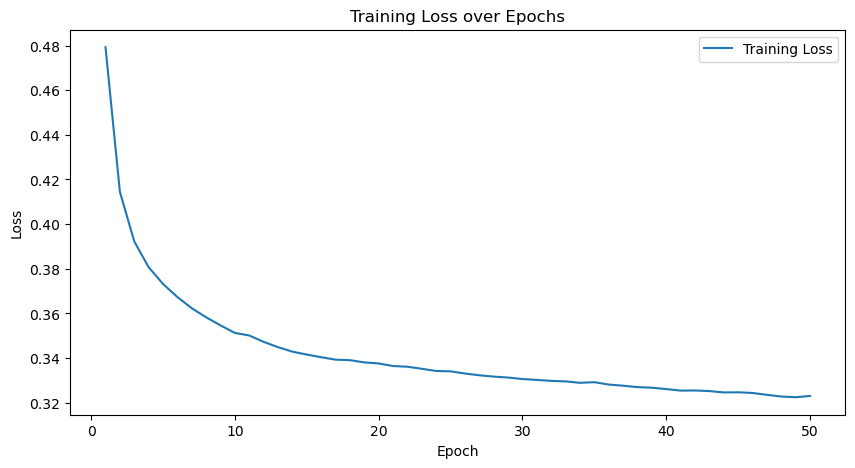

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [30]:
# 评估模型
def evaluate_model():
    model.eval()
    reconstructed = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            outputs = model(data)
            reconstructed.extend(outputs.cpu().numpy())
    
    reconstructed = np.array(reconstructed)
    rmse = sqrt(mean_squared_error(user_movie_matrix_np, reconstructed))
    print(f'RMSE: {rmse:.4f}')

    # 将原始矩阵和重构矩阵四舍五入到最近的整数，以计算分类指标
    y_true = user_movie_matrix_np.flatten()
    y_pred = reconstructed.flatten()

    y_true = np.round(y_true).clip(1, 5).astype(int)
    y_pred = np.round(y_pred).clip(1, 5).astype(int)

    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# 评估模型
evaluate_model()

RMSE: 0.8747
Precision: 0.2436, Recall: 0.2173, F1-Score: 0.2178


In [31]:
# 示例使用
def recommend_movies(user_id, n=10):
    user_index = user_id - 1  # 假设用户ID从1开始
    user_vector = torch.tensor(user_movie_matrix_np[user_index], dtype=torch.float).to(device)
    with torch.no_grad():
        reconstructed_vector = model(user_vector).cpu().numpy()
    
    recommended_movie_indices = reconstructed_vector.argsort()[-n:][::-1]
    recommended_movie_ids = [user_movie_matrix.columns[i] for i in recommended_movie_indices]
    recommended_movies = movies[movies['MovieID'].isin(recommended_movie_ids)]
    return recommended_movies

# 示例使用
user_id = 1
recommended_movies = recommend_movies(user_id)
print(f'Recommended movies for user {user_id}:\n', recommended_movies[['Title', 'Genres']])

Recommended movies for user 1:
                                  Title                               Genres
0                     Toy Story (1995)          Animation|Children's|Comedy
33                         Babe (1995)              Children's|Comedy|Drama
315   Shawshank Redemption, The (1994)                                Drama
360              Lion King, The (1994)         Animation|Children's|Musical
584                     Aladdin (1992)  Animation|Children's|Comedy|Musical
591        Beauty and the Beast (1991)         Animation|Children's|Musical
907           Wizard of Oz, The (1939)   Adventure|Children's|Drama|Musical
1250         Back to the Future (1985)                        Comedy|Sci-Fi
2286              Bug's Life, A (1998)          Animation|Children's|Comedy
3045                Toy Story 2 (1999)          Animation|Children's|Comedy


### 基于嵌入层的协同过滤方法

In [32]:
# 1. 加载并预处理数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [33]:
# 编码用户特征
user_id_enc = LabelEncoder()
users['UserID'] = user_id_enc.fit_transform(users['UserID'])

gender_enc = LabelEncoder()
users['Gender'] = gender_enc.fit_transform(users['Gender'])

age_enc = LabelEncoder()
users['Age'] = age_enc.fit_transform(users['Age'])

occupation_enc = LabelEncoder()
users['Occupation'] = occupation_enc.fit_transform(users['Occupation'])

# 编码电影特征
movie_id_enc = LabelEncoder()
movies['MovieID'] = movie_id_enc.fit_transform(movies['MovieID'])

# 处理电影类型并保存原始类型
original_genres = movies['Genres'].apply(lambda x: x.split('|')[0])
genre_enc = LabelEncoder()
movies['Genres'] = genre_enc.fit_transform(original_genres)

# 创建电影ID到类型的映射
movie_id_to_genre = dict(zip(movies['MovieID'], original_genres))

# 合并数据
data = pd.merge(pd.merge(ratings, users), movies)

In [34]:
# 2. 构建特征向量
user_features = data[['UserID', 'Gender', 'Age', 'Occupation']].values
movie_features = data[['MovieID', 'Genres']].values
ratings = data['Rating'].values

In [35]:

# 3. 自定义数据集类
class MovieLensDataset(Dataset):
    def __init__(self, user_features, movie_features, ratings):
        self.user_features = torch.tensor(user_features, dtype=torch.long)
        self.movie_features = torch.tensor(movie_features, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_features[idx], self.movie_features[idx], self.ratings[idx]

# 4. 构建神经网络模型
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, num_genders, num_ages, num_occupations, num_genres, embedding_size=50):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.gender_embedding = nn.Embedding(num_genders, embedding_size // 4)
        self.age_embedding = nn.Embedding(num_ages, embedding_size // 4)
        self.occupation_embedding = nn.Embedding(num_occupations, embedding_size // 4)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.genre_embedding = nn.Embedding(num_genres, embedding_size // 4)

        total_embedding_size = embedding_size + (embedding_size // 4) * 3 + embedding_size + (embedding_size // 4)
        self.fc1 = nn.Linear(total_embedding_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user, movie):
        user_embed = torch.cat([
            self.user_embedding(user[:, 0]),
            self.gender_embedding(user[:, 1]),
            self.age_embedding(user[:, 2]),
            self.occupation_embedding(user[:, 3])
        ], dim=-1)
        
        movie_embed = torch.cat([
            self.movie_embedding(movie[:, 0]),
            self.genre_embedding(movie[:, 1])
        ], dim=-1)

        x = torch.cat([user_embed, movie_embed], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 5. 数据准备
num_users = len(user_id_enc.classes_)
num_movies = len(movie_id_enc.classes_)
num_genders = len(gender_enc.classes_)
num_ages = len(age_enc.classes_)
num_occupations = len(occupation_enc.classes_)
num_genres = len(genre_enc.classes_)

dataset = MovieLensDataset(user_features, movie_features, ratings)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 6. 模型训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecommenderNet(num_users, num_movies, num_genders, num_ages, num_occupations, num_genres).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for user, movie, rating in train_loader:
            user, movie, rating = user.to(device), movie.to(device), rating.to(device)
            optimizer.zero_grad()
            outputs = model(user, movie).squeeze()
            loss = criterion(outputs, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * user.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for user, movie, rating in val_loader:
                user, movie, rating = user.to(device), movie.to(device), rating.to(device)
                outputs = model(user, movie).squeeze()
                loss = criterion(outputs, rating)
                val_loss += loss.item() * user.size(0)
                y_true.extend(rating.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Val Loss over Epochs')
    plt.legend()
    plt.show()

    return y_true, y_pred

def calculate_metrics(y_true, y_pred, threshold=3.5):
    y_pred_class = [1 if pred >= threshold else 0 for pred in y_pred]
    y_true_class = [1 if true >= threshold else 0 for true in y_true]
    
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    precision = precision_score(y_true_class, y_pred_class, zero_division=1)
    recall = recall_score(y_true_class, y_pred_class, zero_division=1)
    f1 = f1_score(y_true_class, y_pred_class, zero_division=1)
    
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.9691, Val Loss: 0.8581
Epoch 2/10, Train Loss: 0.8441, Val Loss: 0.8447
Epoch 3/10, Train Loss: 0.8202, Val Loss: 0.8403
Epoch 4/10, Train Loss: 0.8018, Val Loss: 0.8315
Epoch 5/10, Train Loss: 0.7863, Val Loss: 0.8198
Epoch 6/10, Train Loss: 0.7715, Val Loss: 0.8139
Epoch 7/10, Train Loss: 0.7569, Val Loss: 0.8126
Epoch 8/10, Train Loss: 0.7413, Val Loss: 0.8124
Epoch 9/10, Train Loss: 0.7256, Val Loss: 0.8212
Epoch 10/10, Train Loss: 0.7095, Val Loss: 0.8179


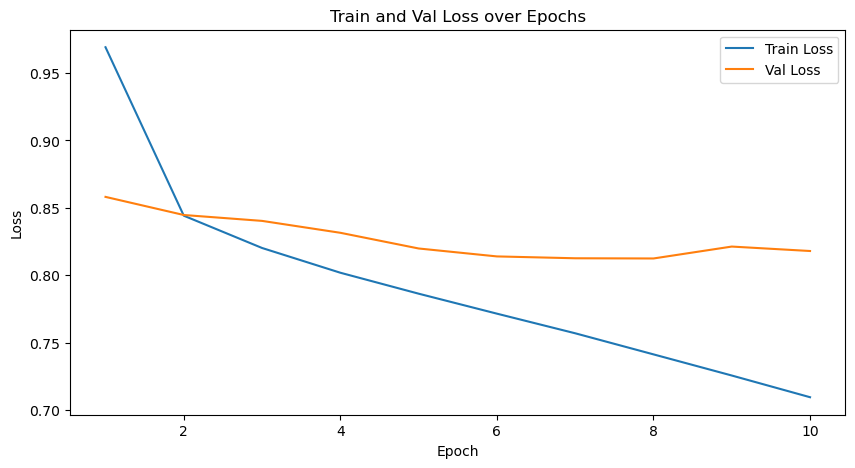

RMSE: 0.9044
MAE: 0.7117
Precision: 0.7456
Recall: 0.7898
F1 Score: 0.7671


In [36]:
# 示例调用
y_true, y_pred = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
calculate_metrics(y_true, y_pred)

In [37]:
# 7. 进行推荐
def recommend_movies(model, user_id, num_recommendations=10):
    model.eval()
    user_data = np.array([[user_id, users[users['UserID'] == user_id]['Gender'].values[0], users[users['UserID'] == user_id]['Age'].values[0], users[users['UserID'] == user_id]['Occupation'].values[0]]])
    user_data = torch.tensor(user_data, dtype=torch.long).to(device)
    
    movie_ids = movies['MovieID'].values
    movie_genres = movies['Genres'].values
    movie_data = np.array(list(zip(movie_ids, movie_genres)))
    movie_data = torch.tensor(movie_data, dtype=torch.long).to(device)
    
    with torch.no_grad():
        predictions = model(user_data.repeat(len(movie_ids), 1), movie_data).cpu().numpy().flatten()
    
    top_movie_indices = predictions.argsort()[-num_recommendations:][::-1]
    recommended_movies = movies.iloc[top_movie_indices]
    recommended_movies['Genres'] = recommended_movies['MovieID'].map(movie_id_to_genre)
    return recommended_movies


In [38]:
user_id = 1  # 示例用户ID
recommended_movies = recommend_movies(model, user_id)
print(recommended_movies[['Title', 'Genres']])

                                                  Title      Genres
2028             Something Wicked This Way Comes (1983)  Children's
1223       Rosencrantz and Guildenstern Are Dead (1990)      Comedy
668                                   Barbarella (1968)   Adventure
2503                  10 Things I Hate About You (1999)      Comedy
356                               I Love Trouble (1994)      Action
318   Strawberry and Chocolate (Fresa y chocolate) (...       Drama
1291                          Santa with Muscles (1996)      Comedy
2905                                        Bats (1999)      Horror
1224                                   Manhattan (1979)      Comedy
260                            Ladybird Ladybird (1994)       Drama


C:\Users\funny\AppData\Local\Temp\ipykernel_26588\374433771.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_movies['Genres'] = recommended_movies['MovieID'].map(movie_id_to_genre)


### 协调过滤、内容过滤、混合推荐——年龄、性别、职业、电影类型

In [39]:
import pandas as pd
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# 加载数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

# 数据预处理
age_encoder = LabelEncoder()
occupation_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
users['Age'] = age_encoder.fit_transform(users['Age'])
users['Occupation'] = occupation_encoder.fit_transform(users['Occupation'])
users['Gender'] = gender_encoder.fit_transform(users['Gender'])

# 使用TF-IDF对电影的类型进行编码
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['Genres']).toarray()

# 将TF-IDF矩阵转换为DataFrame，以便后续操作
tfidf_df = pd.DataFrame(tfidf_matrix, index=movies['MovieID'])

# 计算电影类型相似度矩阵
cosine_sim = cosine_similarity(tfidf_matrix)

# 合并用户数据、评分数据和电影类型数据
merged_data = pd.merge(ratings, users, on='UserID')
merged_data = pd.merge(merged_data, movies[['MovieID', 'Genres']], on='MovieID')
merged_data = pd.merge(merged_data, tfidf_df, left_on='MovieID', right_index=True)

# 加载Surprise数据集
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_data[['UserID', 'MovieID', 'Rating']], reader)

# 训练和测试数据集划分
trainset, testset = train_test_split(data, test_size=0.2)

# 使用SVD进行协同过滤
svd = SVD()
svd.fit(trainset)

# 评价模型性能
predictions = svd.test(testset)
print("RMSE: ", accuracy.rmse(predictions))
print("MAE: ", accuracy.mae(predictions))

# 协同过滤推荐
def collaborative_filtering_recommendations(user_id, n=10):
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_watched = user_ratings['MovieID'].tolist()
    movie_ids = movies['MovieID'].tolist()
    recommendations = []
    for movie_id in movie_ids:
        if movie_id not in user_watched:
            est = svd.predict(user_id, movie_id).est
            recommendations.append((movie_id, est))
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    top_n_recommendations = [(movies[movies['MovieID'] == movie_id]['Title'].values[0], movies[movies['MovieID'] == movie_id]['Genres'].values[0]) for movie_id, _ in recommendations[:n]]
    return top_n_recommendations

# 内容过滤推荐（使用缓存）
content_sim_cache = {}

def content_based_recommendations(title, n=10):
    if title in content_sim_cache:
        return content_sim_cache[title]
    idx = movies[movies['Title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_n_similar = [(movies['Title'].iloc[i[0]], movies['Genres'].iloc[i[0]]) for i in sim_scores[1:n+1]]
    content_sim_cache[title] = top_n_similar
    return top_n_similar

# 混合推荐
def hybrid_recommendations(user_id, title, alpha=0.5, n=10):
    content_recs = content_based_recommendations(title, n)
    collab_recs = collaborative_filtering_recommendations(user_id, n)
    
    content_recs_set = set(content_recs)
    collab_recs_set = set(collab_recs)
    
    common_recs = content_recs_set.intersection(collab_recs_set)
    unique_recs = content_recs_set.union(collab_recs_set) - common_recs
    
    final_recs = list(common_recs) + list(unique_recs)
    return final_recs[:n]

# 模型评估
def evaluate_collaborative_model():
    y_true = []
    y_pred = []
    for uid, iid, true_r in testset:
        y_true.append(true_r)
        y_pred.append(round(svd.predict(uid, iid).est))  # 将预测值四舍五入以转化为离散值
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f'Collaborative Filtering - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

def evaluate_content_based_model():
    y_true = []
    y_pred = []
    for uid, iid, true_r in testset:
        movie_title = movies[movies['MovieID'] == iid]['Title'].values[0]
        recommendations = content_based_recommendations(movie_title, 10)
        recommended_movie_ids = [movies[movies['Title'] == rec[0]]['MovieID'].values[0] for rec in recommendations]
        if iid in recommended_movie_ids:
            y_pred.append(1)
        else:
            y_pred.append(0)
        y_true.append(1 if true_r >= 3.5 else 0)
    
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f'Content-Based Filtering - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

def evaluate_hybrid_model():
    y_true = []
    y_pred = []
    for uid, iid, true_r in testset:
        # 获取协同过滤的预测值
        svd_est = svd.predict(uid, iid).est
        movie_title = movies[movies['MovieID'] == iid]['Title'].values[0]
        content_recs = content_based_recommendations(movie_title, 10)
        content_est = 5 if movie_title in [rec[0] for rec in content_recs] else 0
        
        # 计算混合预测值
        hybrid_est = (svd_est + content_est) / 2
        y_true.append(true_r)
        y_pred.append(round(hybrid_est))
    
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f'Hybrid Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# 示例使用
user_id = 1
movie_title = "Toy Story (1995)"
print("协同过滤推荐:", collaborative_filtering_recommendations(user_id))
print("内容过滤推荐:", content_based_recommendations(movie_title))
print("混合推荐:", hybrid_recommendations(user_id, movie_title))

# 评估模型
evaluate_collaborative_model()
evaluate_content_based_model()
evaluate_hybrid_model()

RMSE: 0.8733
RMSE:  0.8733030259487443
MAE:  0.6857
MAE:  0.6857427117213
协同过滤推荐: [("It's a Wonderful Life (1946)", 'Drama'), ('Sanjuro (1962)', 'Action|Adventure'), ('Casablanca (1942)', 'Drama|Romance|War'), ('For All Mankind (1989)', 'Documentary'), ('Palm Beach Story, The (1942)', 'Comedy'), ('Killer, The (Die xue shuang xiong) (1989)', 'Action|Thriller'), ('Dersu Uzala (1974)', 'Adventure|Drama'), ('Paths of Glory (1957)', 'Drama|War'), ('October Sky (1999)', 'Drama'), ('On the Beach (1959)', 'Drama')]
内容过滤推荐: [('Aladdin and the King of Thieves (1996)', "Animation|Children's|Comedy"), ('American Tail, An (1986)', "Animation|Children's|Comedy"), ('American Tail: Fievel Goes West, An (1991)', "Animation|Children's|Comedy"), ('Rugrats Movie, The (1998)', "Animation|Children's|Comedy"), ("Bug's Life, A (1998)", "Animation|Children's|Comedy"), ('Toy Story 2 (1999)', "Animation|Children's|Comedy"), ('Saludos Amigos (1943)', "Animation|Children's|Comedy"), ('Chicken Run (2000)', "Animati

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import numpy as np

# 1. 加载并预处理数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

# 编码用户特征
user_id_enc = LabelEncoder()
users['UserID'] = user_id_enc.fit_transform(users['UserID'])

gender_enc = LabelEncoder()
users['Gender'] = gender_enc.fit_transform(users['Gender'])

age_enc = LabelEncoder()
users['Age'] = age_enc.fit_transform(users['Age'])

occupation_enc = LabelEncoder()
users['Occupation'] = occupation_enc.fit_transform(users['Occupation'])

# 编码电影特征
movie_id_enc = LabelEncoder()
movies['MovieID'] = movie_id_enc.fit_transform(movies['MovieID'])

# 处理电影类型并保存原始类型
original_genres = movies['Genres'].apply(lambda x: x.split('|')[0])
genre_enc = LabelEncoder()
movies['Genres'] = genre_enc.fit_transform(original_genres)

# 创建电影ID到类型的映射
movie_id_to_genre = dict(zip(movies['MovieID'], original_genres))

# 合并数据
data = pd.merge(pd.merge(ratings, users), movies)

# 2. 构建特征向量
user_features = data[['UserID', 'Gender', 'Age', 'Occupation']].values
movie_features = data[['MovieID', 'Genres']].values
ratings = data['Rating'].values

# 3. 自定义数据集类
class MovieLensDataset(Dataset):
    def __init__(self, user_features, movie_features, ratings):
        self.user_features = torch.tensor(user_features, dtype=torch.long)
        self.movie_features = torch.tensor(movie_features, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_features[idx], self.movie_features[idx], self.ratings[idx]

# 4. 构建神经网络模型
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, num_genders, num_ages, num_occupations, num_genres, embedding_size=50):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.gender_embedding = nn.Embedding(num_genders, embedding_size // 4)
        self.age_embedding = nn.Embedding(num_ages, embedding_size // 4)
        self.occupation_embedding = nn.Embedding(num_occupations, embedding_size // 4)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.genre_embedding = nn.Embedding(num_genres, embedding_size // 4)

        total_embedding_size = embedding_size + (embedding_size // 4) * 3 + embedding_size + (embedding_size // 4)
        self.fc1 = nn.Linear(total_embedding_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user, movie):
        user_embed = torch.cat([
            self.user_embedding(user[:, 0]),
            self.gender_embedding(user[:, 1]),
            self.age_embedding(user[:, 2]),
            self.occupation_embedding(user[:, 3])
        ], dim=-1)
        
        movie_embed = torch.cat([
            self.movie_embedding(movie[:, 0]),
            self.genre_embedding(movie[:, 1])
        ], dim=-1)

        x = torch.cat([user_embed, movie_embed], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 5. 数据准备
num_users = len(user_id_enc.classes_)
num_movies = len(movie_id_enc.classes_)
num_genders = len(gender_enc.classes_)
num_ages = len(age_enc.classes_)
num_occupations = len(occupation_enc.classes_)
num_genres = len(genre_enc.classes_)

dataset = MovieLensDataset(user_features, movie_features, ratings)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 6. 模型训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecommenderNet(num_users, num_movies, num_genders, num_ages, num_occupations, num_genres).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for user, movie, rating in train_loader:
            user, movie, rating = user.to(device), movie.to(device), rating.to(device)
            optimizer.zero_grad()
            outputs = model(user, movie).squeeze()
            loss = criterion(outputs, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * user.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for user, movie, rating in val_loader:
                user, movie, rating = user.to(device), movie.to(device), rating.to(device)
                outputs = model(user, movie).squeeze()
                loss = criterion(outputs, rating)
                val_loss += loss.item() * user.size(0)
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(rating.cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        mae = mean_absolute_error(all_targets, all_preds)
        
        # 将评分转换为二分类任务的标签（例如，评分 >= 4 为正类，否则为负类）
        binary_targets = (all_targets >= 4).astype(int)
        binary_preds = (all_preds >= 4).astype(int)
        precision = precision_score(binary_targets, binary_preds)
        recall = recall_score(binary_targets, binary_preds)
        f1 = f1_score(binary_targets, binary_preds)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# 7. 进行推荐
def recommend_movies(model, user_id, num_recommendations=10):
    model.eval()
    user_data = np.array([[user_id, users[users['UserID'] == user_id]['Gender'].values[0], users[users['UserID'] == user_id]['Age'].values[0], users[users['UserID'] == user_id]['Occupation'].values[0]]])
    user_data = torch.tensor(user_data, dtype=torch.long).to(device)
    
    movie_ids = movies['MovieID'].values
    movie_genres = movies['Genres'].values
    movie_data = np.array(list(zip(movie_ids, movie_genres)))
    movie_data = torch.tensor(movie_data, dtype=torch.long).to(device)
    
    with torch.no_grad():
        predictions = model(user_data.repeat(len(movie_ids), 1), movie_data).cpu().numpy().flatten()
    
    top_movie_indices = predictions.argsort()[-num_recommendations:][::-1]
    recommended_movies = movies.iloc[top_movie_indices]
    recommended_movies['Genres'] = recommended_movies['MovieID'].map(movie_id_to_genre)
    return recommended_movies

user_id = 1  # 示例用户ID
recommended_movies = recommend_movies(model, user_id)
print(recommended_movies[['Title', 'Genres']])



Epoch 1/10, Train Loss: 0.9713, Val Loss: 0.8833, RMSE: 0.9398, MAE: 0.7338, Precision: 0.8118, Recall: 0.5186, F1 Score: 0.6329
Epoch 2/10, Train Loss: 0.8457, Val Loss: 0.8389, RMSE: 0.9159, MAE: 0.7241, Precision: 0.8442, Recall: 0.4108, F1 Score: 0.5526
Epoch 3/10, Train Loss: 0.8225, Val Loss: 0.8302, RMSE: 0.9112, MAE: 0.7162, Precision: 0.8396, Recall: 0.4489, F1 Score: 0.5850
Epoch 4/10, Train Loss: 0.8058, Val Loss: 0.8290, RMSE: 0.9105, MAE: 0.7130, Precision: 0.8320, Recall: 0.4851, F1 Score: 0.6129
Epoch 5/10, Train Loss: 0.7905, Val Loss: 0.8198, RMSE: 0.9055, MAE: 0.7122, Precision: 0.8452, Recall: 0.4353, F1 Score: 0.5747
Epoch 6/10, Train Loss: 0.7764, Val Loss: 0.8250, RMSE: 0.9083, MAE: 0.7201, Precision: 0.8618, Recall: 0.3624, F1 Score: 0.5102
Epoch 7/10, Train Loss: 0.7631, Val Loss: 0.8182, RMSE: 0.9046, MAE: 0.7113, Precision: 0.8467, Recall: 0.4303, F1 Score: 0.5706
Epoch 8/10, Train Loss: 0.7487, Val Loss: 0.8183, RMSE: 0.9046, MAE: 0.7112, Precision: 0.8457, R

C:\Users\funny\AppData\Local\Temp\ipykernel_26588\4275657357.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_movies['Genres'] = recommended_movies['MovieID'].map(movie_id_to_genre)


In [41]:
user_id = 1  # 示例用户ID
recommended_movies = recommend_movies(model, user_id)
recommended_movies[['Title', 'Genres']]

C:\Users\funny\AppData\Local\Temp\ipykernel_26588\4275657357.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_movies['Genres'] = recommended_movies['MovieID'].map(movie_id_to_genre)


,Title,Genres
1802,"Friend of the Deceased, A (1997)",Comedy
557,Killer (Bulletproof Heart) (1994),Thriller
3338,"Carriers Are Waiting, The (Les Convoyeurs Atte...",Comedy
3656,American Pop (1981),Animation
150,"Addiction, The (1995)",Horror
598,"Great Day in Harlem, A (1994)",Documentary
326,Tales from the Hood (1995),Comedy
1210,Raging Bull (1980),Drama
3517,"Idolmaker, The (1980)",Drama
746,Carmen Miranda: Bananas Is My Business (1994),Documentary
